# Transforming excel to df

In [59]:
import os 
from glob import glob
import pandas as pd
import numpy as np

In [19]:
#!pip install xlrd

     |████████████████████████████████| 103 kB 427 kB/s eta 0:00:01


In [6]:
import xlrd

### 1. Using `xlrd`

In [2]:
path = '../../Donnees_indices_fragilites_numeriques/'


#### Find path of xls into TauxdePauvrete folder


In [3]:
list_files= glob(os.path.join(path,'**/**/2019/*.xls'))
list_files[0]

'../../Donnees_indices_fragilites_numeriques/1 - Accès aux interfaces numériques/1 - Taux de pauvreté/2019/2A - Corse du Sud.xls'

# 1. Method to create dataframe

In [4]:
def create_dataframe(filename,columns = ['Dep','Commune','Libelle','revenu_fiscal_ref','num_foyers_fiscal'],start_row=23,start_col=1,end_col = 6):
    # load the first sheet
    wb = xlrd.open_workbook(filename=filename)
    sheet = wb.sheet_by_index(0)   
    data = [sheet.row_values(i,start_colx=start_col,end_colx=end_col) for i in range(start_row,sheet.nrows)]  # get the info
    df = pd.DataFrame(data,columns=columns)
    df['Dep'] = df['Dep'].transform(lambda x: x[:2]) #convert 060 to 06 (departement)
    return df

In [7]:
# Example 
df = create_dataframe(list_files[7])
df.head()

,Dep,Commune,Libelle,revenu_fiscal_ref,num_foyers_fiscal
0,06,001,Aiglun,Total,49
1,06,002,Amirat,Total,21
2,06,003,Andon,Total,348
3,06,004,Antibes,0 à 10 000,10235
4,06,004,Antibes,10 001 à 12 000,2526


In [24]:
df.isna().sum()

Dep                  0
Commune              0
Libelle              0
revenu_fiscal_ref    0
num_foyers_fiscal    0
dtype: int64

### pivot table revenu


In [7]:
for i,c in enumerate(list_files):
    if 'Corse' in c:
        print(i)

0
30


# 2. Method to get taux by deparment

####### changes a faire
1. NAN --- 0
2. Taux dans pourcentage
3. CODE (00)(000)

In [8]:
def get_info(file):
    # Method to get info
    df = create_dataframe(file)
    # pivot table to change revenu to columns
    table = pd.pivot_table(df, values='num_foyers_fiscal', index=['Dep','Commune','Libelle'],
                           columns=['revenu_fiscal_ref'], aggfunc=np.sum,fill_value=0).reset_index()
    # ----- calculating indices
    nx_10k = table['0 à 10 000']=='n.c.'
    nx_12k = table['10 001 à 12 000']=='n.c.'
    nx_total = table['Total'] =='n.c.'
    if table.loc[nx_10k,'Libelle'].count(): print('****N.C. in 10K\n',table.loc[nx_10k,['Dep','Libelle']])
    if table.loc[nx_12k,'Libelle'].count(): print('****N.C. in 12K\n',table.loc[nx_12k,['Dep','Libelle']])
    if table.loc[nx_total,'Libelle'].count(): print('****N.C. in Total\n',table.loc[nx_total,['Dep','Libelle']])


# information

> Notes from original file:
    - données disponibles uniquement pour 468/4454 communes
    - pour les 3986 communes restantes, le taux de pauvreté du département respectif a été pris en compte

In [9]:
#dataframe_total = pd.DataFrame(columns=['Libelle','num_foyers','Total','TX_POVERTY'])
for file in list_files[:5]:
    print("[[[{}]]] ".format(file.split('-')[-1]))
    df = get_info(file)
    #dataframe_total = pd.concat([dataframe_total,df])

[[[ Corse du Sud.xls]]] 
[[[ Drome.xls]]] 
****N.C. in 12K
 revenu_fiscal_ref Dep                   Libelle
312                26  Saint-Sorlin-en-Valloire
****N.C. in Total
 revenu_fiscal_ref Dep             Libelle
15                 26             Aucelon
16                 26               Aulan
27                 26  La Bâtie-des-Fonds
142                26     Izon-la-Bruisse
228                26   Le Poët-en-Percip
231                26            Pommerol
258                26       Rochefourchat
333                26          Les Tonils
[[[ Mayotte.xls]]] 
****N.C. in 12K
 revenu_fiscal_ref Dep        Libelle
0                  97          Acoua
1                  97     Bandraboua
3                  97         Bouéni
4                  97        Chiconi
8                  97      Kani-Kéli
11                 97      Mtsamboro
12                 97  M'Tsangamouji
13                 97       Ouangani
[[[ Taux de pauvreté/2019/430.xls]]] 
****N.C. in 12K
 revenu_fiscal_ref Dep 

In [8]:
def get_data(file):
    # 1. create dataframe from excel : ['Dep','Commune','Libelle','revenu_fiscal_ref','num_foyers_fiscal']
    # 2. NaN fill with 0 !
    df = create_dataframe(file)
    # pivot table to change revenu to columns
    table = pd.pivot_table(df, values='num_foyers_fiscal', index=['Dep','Commune','Libelle'],
                           columns=['revenu_fiscal_ref'], aggfunc=np.sum).reset_index()
    # ----- calculating indices
    # n.c. to Nan  num_foyers < 12 000
    table.loc[table['0 à 10 000'] == 'n.c.','0 à 10 000'] = np.nan
    table.loc[table['10 001 à 12 000']  == 'n.c.', '10 001 à 12 000'] = np.nan
    table.loc[table['Total']  == 'n.c.','Total'] = np.nan
    
    # TX_POVERTY = (number_foyers10k + number_foyers12k) / total
    taux = []
    for foyers_10k,foyers_12k,total in zip(table['0 à 10 000'],table['10 001 à 12 000'],table['Total']):
        if foyers_10k != np.nan and foyers_12k != np.nan:
            taux.append(((foyers_10k + foyers_12k) / total) * 100)
        elif foyers_10k == np.nan:
            taux.append(((foyers_12k) / total) * 100)
        else:
            taux.append(((foyers_10k) / total) * 100)
            
    table['TX_POVERTY'] = taux
    table['CODE_INSEE'] = table['Dep'] + table['Commune']
    return table[['CODE_INSEE','TX_POVERTY']]
    

# Testing 

# Where are the NaNs ?

In [12]:
dep06= get_data(list_files[7])
print(dep06.isna().sum())

revenu_fiscal_ref
CODE_INSEE      0
TX_POVERTY    103
dtype: int64


In [13]:
dep06.head()

revenu_fiscal_ref,CODE_INSEE,TX_POVERTY
0,06001,NaN
1,06002,NaN
2,06003,NaN
3,06004,24.384232
4,06005,NaN


In [10]:
## testing with data_gps.
data_gps = pd.read_csv('../data/external/data_gps.csv')
data_gps['code_INSEE'] = ['0'+str(X) if len(str(X)) < 5 else X for X in data_gps['code_INSEE']]
data_gps.columns = ['CODE_INSEE','latitude','longitude']

In [11]:
data_gps.head()

,CODE_INSEE,latitude,longitude
0,38075,45.461591,5.958008
1,38081,45.538065,5.116091
2,38085,45.739851,5.151117
3,38089,45.501096,5.512872
4,38092,45.054233,5.389574


In [14]:
data = pd.merge(dep06,data_gps,on='CODE_INSEE')
data.head()

,CODE_INSEE,TX_POVERTY,latitude,longitude
0,06001,NaN,43.852419,6.934942
1,06002,NaN,43.896297,6.812560
2,06003,NaN,43.776986,6.823186
3,06003,NaN,43.776986,6.823186
4,06004,24.384232,43.587465,7.106354


In [15]:
BBox = ((data.longitude.min(), data.longitude.max(),      
         data.latitude.min(), data.latitude.max()))
BBox

(6.690432969600001, 7.65147828925, 43.4985345439, 44.2894656829)

In [16]:
import matplotlib.pyplot as plt

In [ ]:
#conda install basemap

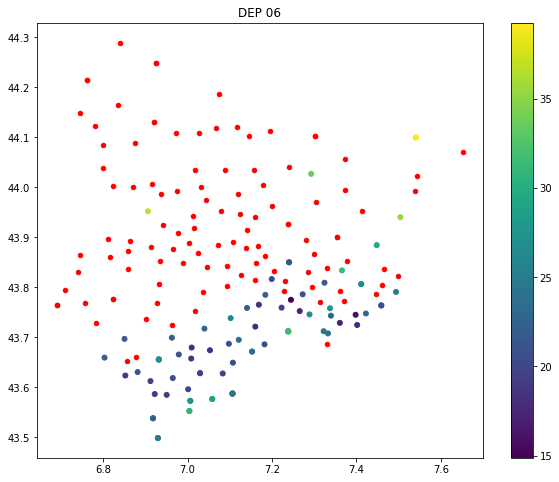

In [17]:
data = pd.merge(dep06,data_gps,on='CODE_INSEE')
data.head()
fig, ax = plt.subplots(figsize = (10,8))
index = data.TX_POVERTY.isna()
ax.scatter(data.longitude[index], data.latitude[index], c='r', s=20)
sc = ax.scatter(data.longitude[-index], data.latitude[-index], c=data.TX_POVERTY[-index], s=25)
plt.title('DEP 06')
fig.colorbar(sc)
plt.show()

In [18]:
for i,c in enumerate(list_files):
    if '29' in c:
        print(i)

70


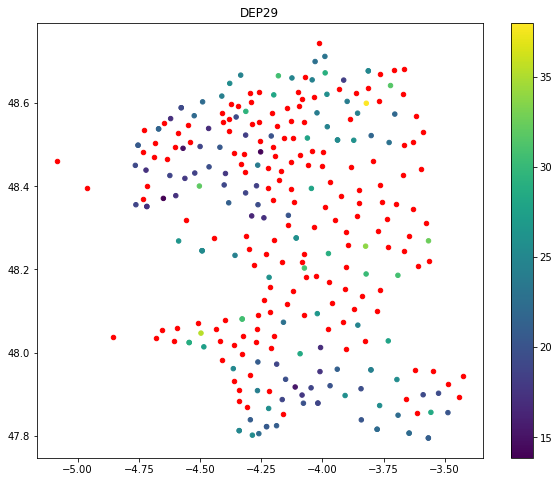

In [19]:
data = pd.merge(get_data(list_files[70]),data_gps,on='CODE_INSEE')

fig, ax = plt.subplots(figsize = (10,8))
index = data.TX_POVERTY.isna()
ax.scatter(data.longitude[index], data.latitude[index], c='r', s=20)
sc = ax.scatter(data.longitude[-index], data.latitude[-index], c=data.TX_POVERTY[-index], s=20)
plt.title('DEP29')
fig.colorbar(sc)
plt.show()

# Create big csv 

In [20]:
dataframe_total = pd.DataFrame(columns=['CODE_INSEE','TX_POVERTY'])
for file in list_files:
    #print("[[[{}]]] ".format(file.split('-')[-1]))
    # create dataset by departement and concatenate
    df = get_data(file)
    dataframe_total = pd.concat([dataframe_total,df])


In [21]:
dataframe_total.head()

revenu_fiscal_ref,CODE_INSEE,TX_POVERTY
0,2A001,17.815483
1,2A004,27.441333
2,2A006,17.826087
3,2A008,NaN
4,2A011,NaN


In [22]:
dataframe_total.isna().sum()

revenu_fiscal_ref
CODE_INSEE        0
TX_POVERTY    29642
dtype: int64

In [17]:
#dataframe_total.to_csv('../data/taux_pauvrete.csv',index=False)

Two approaches to complete the data.
1. mean
2. clustering

In [23]:
list_files[15]

'../../Donnees_indices_fragilites_numeriques/1 - Accès aux interfaces numériques/1 - Taux de pauvreté/2019/470.xls'

## Nan to median by department

In [61]:
dataframe_total_median = pd.DataFrame(columns=['CODE_INSEE','TX_POVERTY'])
for file in list_files:
    #print("[[[{}]]] nan median".format(file.split('-')[-1]))
    # create dataset by departement and concatenate
    df = get_data(file)
    # add median
    df_median = df.fillna(value=df.TX_POVERTY.median())
    dataframe_total_median = pd.concat([dataframe_total_median,df_median])


In [62]:
dataframe_total_mean = pd.DataFrame(columns=['CODE_INSEE','TX_POVERTY'])
for file in list_files:
    #print("[[[{}]]] nan median".format(file.split('-')[-1]))
    # create dataset by departement and concatenate
    df = get_data(file)
    # add median
    df_mean = df.fillna(value=df.TX_POVERTY.mean())
    dataframe_total_mean = pd.concat([dataframe_total_mean,df_mean])


# Data viz

In [63]:
data = pd.merge(dataframe_total,data_gps,on='CODE_INSEE')
data_fill_median = pd.merge(dataframe_total_median,data_gps,on='CODE_INSEE')
data_fill_mean = pd.merge(dataframe_total_mean,data_gps,on='CODE_INSEE')

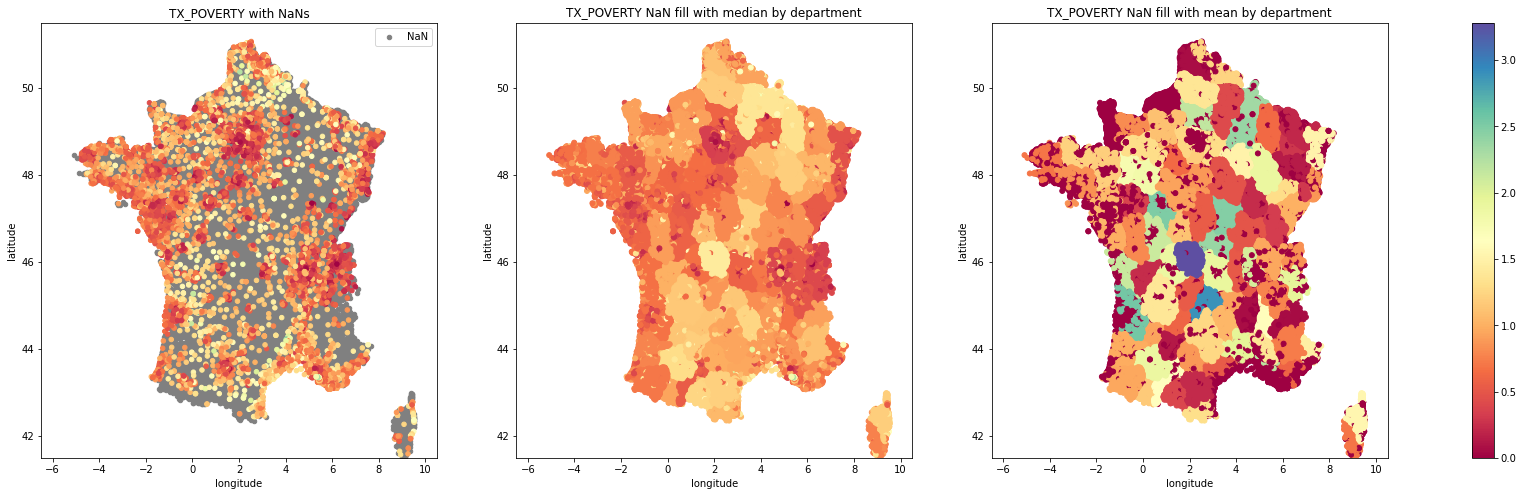

In [64]:
fig, ax = plt.subplots(1,3,figsize = (28,8))
index = data.TX_POVERTY.isna()
ax[0].scatter(data.longitude[index], data.latitude[index], c='gray', s=20,label="NaN")
sc = ax[0].scatter(data.longitude[-index], data.latitude[-index], c=data.TX_POVERTY[-index], s=20,cmap='Spectral')
#fig.colorbar(sc,ax=ax[0])
ax[0].set_title("TX_POVERTY with NaNs")
ax[0].legend()
sc = ax[1].scatter(data_fill_median.longitude,data_fill_median.latitude, c=data_fill_median.TX_POVERTY, s=25,cmap='Spectral')
ax[1].set_title('TX_POVERTY NaN fill with median by department')
#fig.colorbar(sc,ax=ax[1])

sc = ax[2].scatter(data_fill_mean.longitude,data_fill_mean.latitude, c=np.abs(data_fill_median.TX_POVERTY-data_fill_mean.TX_POVERTY), s=25,cmap='Spectral')
ax[2].set_title('TX_POVERTY NaN fill with mean by department')

fig.subplots_adjust(right=0.96)
fig.colorbar(sc, ax=ax.ravel().tolist())

for i in ax:
    i.set_xlim(-6.5, 10.5)
    i.set_ylim(41.5, 51.5)
    i.set_xlabel('longitude')
    i.set_ylabel('latitude')
#plt.savefig('tx_poverty.png', bbox_inches='tight')
plt.show()

In [65]:
print(dataframe_total_median.tail())
print(dataframe_total_mean.tail())

revenu_fiscal_ref CODE_INSEE  TX_POVERTY
421                    52546   32.358079
422                    52547   32.358079
423                    52548   32.358079
424                    52549   32.358079
425                    52550   33.152828
revenu_fiscal_ref CODE_INSEE  TX_POVERTY
421                    52546   30.454125
422                    52547   30.454125
423                    52548   30.454125
424                    52549   30.454125
425                    52550   33.152828


# export TX_POVERTY

In [98]:
table_reference = pd.read_csv('../data/external/table_iris_insee_epci.csv')[['CODE_INSEE','LIBCOM']]
table_reference = table_reference.drop_duplicates(subset='CODE_INSEE')
print("INSEE ",table_reference.count())

INSEE  CODE_INSEE    35010
LIBCOM        35010
dtype: int64


In [99]:
tx = pd.merge(table_reference,dataframe_total_median,on='CODE_INSEE',how='left')
tx.count()

CODE_INSEE    35010
LIBCOM        35010
TX_POVERTY    35002
dtype: int64

In [100]:
tx.loc[tx.TX_POVERTY.isna(),:]

,CODE_INSEE,LIBCOM,TX_POVERTY
3108,09304,Suzan,NaN
4884,14666,Sannerville,NaN
20072,55039,Beaumont-en-Verdunois,NaN
20083,55050,Bezonvaux,NaN
20158,55139,Cumières-le-Mort-Homme,NaN
20201,55189,Fleury-devant-Douaumont,NaN
20238,55239,Haumont-près-Samogneux,NaN
20297,55307,Louvemont-Côte-du-Poivre,NaN


In [102]:
tx.to_csv('../data/interim/taux_pauvrete.csv',index=False)

# revision  demandeurs

In merge_v2 only 72 valeurs of tx_demandeurs appears. Problem in merge

same notebook cecile

In [103]:
demandeur_emplois = pd.read_csv('../data/raw/data_DEFM2019_com.csv', sep=";")
pop_active = pd.read_csv('../data/raw/base-cc-emploi-pop-active-2016_SHORT.csv')
pop_active2 = pd.read_csv('../data/raw/base-cc-emploi-pop-active-2016-COM.CSV', sep=";")
pop_active2 = pop_active2[['CODGEO', 'P16_ACT1564']]
pop_active = pop_active.append(pop_active2)
pop_active['CODGEO'] = ['0'+str(X) if len(str(X)) < 5 else X for X in pop_active['CODGEO']]
pop_active.head()

,CODGEO,P16_ACT1564
0,01001,376.000000
1,01002,123.000000
2,01004,6697.333122
3,01005,864.845592
4,01006,58.000000


In [104]:
pop_active.count()

CODGEO         35002
P16_ACT1564    35002
dtype: int64

In [105]:
demandeur_emplois['ABC_TOT'] = demandeur_emplois['ABC_25'] + demandeur_emplois['ABC_2649'] + demandeur_emplois['ABC_50']
demandeur_emplois['CODGEO'] = ['0'+str(X) if len(str(X)) < 5 else X for X in demandeur_emplois['CODGEO']]


In [106]:
demandeur_emplois[['CODGEO','ABC_TOT']].count()

CODGEO     1181
ABC_TOT    1180
dtype: int64

In [108]:
data_emploi = pd.merge(demandeur_emplois[['CODGEO','ABC_TOT']],pop_active,on='CODGEO',how='outer')
### calculate TX_DEMANDEURS
data_emploi['TX_DEMANDEUR_EMPLOIS'] = (data_emploi['ABC_TOT'] / data_emploi['P16_ACT1564'])*100
data_emploi.columns = ['CODE_INSEE','ABC_TOT','P16_ACT1564','TX_DEMANDEUR_EMPLOIS']
#print(data_emploi.head(),data_emploi.count())

  CODE_INSEE  ABC_TOT   P16_ACT1564  TX_DEMANDEUR_EMPLOIS
0      01004   1457.0   6697.333122             21.754928
1      01031    375.0   1646.324569             22.778012
2      01033   1470.0   8072.414366             18.210165
3      01034    784.0   3998.000000             19.609805
4      01053   4148.0  17702.022560             23.432351 CODE_INSEE              35002
ABC_TOT                  1180
P16_ACT1564             35002
TX_DEMANDEUR_EMPLOIS     1180
dtype: int64


In [109]:
data_emploi_gps = pd.merge(data_emploi[['CODE_INSEE','TX_DEMANDEUR_EMPLOIS']],data_gps,on='CODE_INSEE')
data_emploi_gps.head()

,CODE_INSEE,TX_DEMANDEUR_EMPLOIS,latitude,longitude
0,01004,21.754928,45.960848,5.372926
1,01031,22.778012,46.237350,5.636005
2,01033,18.210165,46.106790,5.832027
3,01034,19.609805,45.749470,5.684124
4,01053,23.432351,46.205152,5.246021


In [207]:
data_emploi.count()

CODE_INSEE              35002
ABC_TOT                  1180
P16_ACT1564             35002
TX_DEMANDEUR_EMPLOIS     1180
dtype: int64

# method median by department

In [51]:
def fill_with_median(dataframe,column):
    # Get median by department
    df = dataframe.loc[:,['CODE_INSEE',column]]
    df['DEP'] = [str(X)[:2] for X in dataframe['CODE_INSEE']]
    TX_MEDIAN = df.groupby(['DEP']).median().reset_index()
    print("Example median",TX_MEDIAN.loc[0])
    
    # Fill with median
    df_total = pd.DataFrame(columns=['CODE_INSEE',column])
    for dep,median in zip(TX_MEDIAN.DEP,TX_MEDIAN[column]):
        df_department = df.loc[df.DEP == dep,['CODE_INSEE',column]].fillna(value=median)
        df_total = pd.concat([df_department,df_total])
        #print("Fill {} department".format(dep))
    return df_total

### fill demandeurs

In [210]:
column = 'TX_DEMANDEUR_EMPLOIS'
dataframe_total_demandeurs = fill_with_median(data_emploi,column)

Example median DEP                        01
TX_DEMANDEUR_EMPLOIS    18.91
Name: 0, dtype: object


In [211]:
dataframe_total_demandeurs.count()

CODE_INSEE              35002
TX_DEMANDEUR_EMPLOIS    35002
dtype: int64

In [212]:
demandeurs_fill_median = pd.merge(dataframe_total_demandeurs,data_gps,on='CODE_INSEE')
demandeurs_fill_median.head()

,CODE_INSEE,TX_DEMANDEUR_EMPLOIS,latitude,longitude
0,97401,33.737153,-21.208999,55.359149
1,97401,33.737153,-21.208999,55.359149
2,97402,33.635515,-21.023328,55.619585
3,97402,33.635515,-21.023328,55.619585
4,97404,38.331198,-21.249425,55.366793


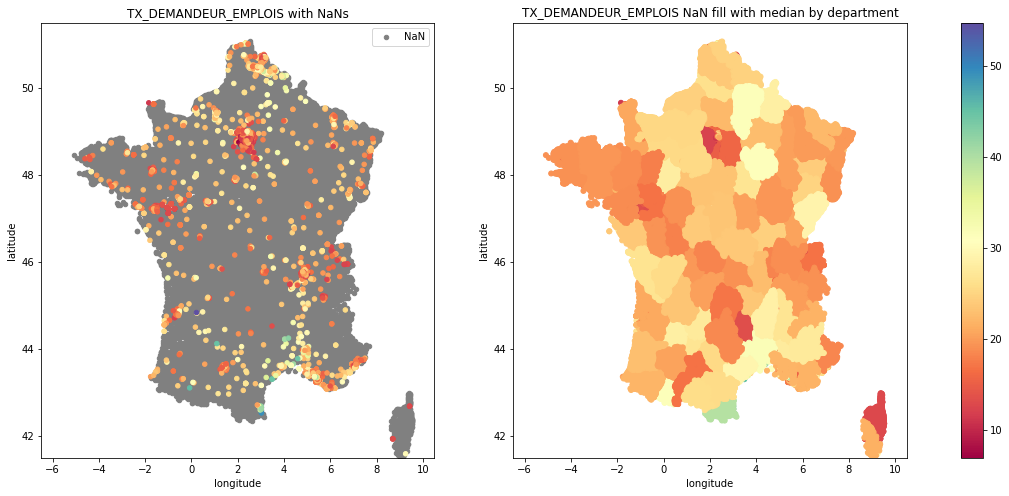

In [203]:
fig, ax = plt.subplots(1,2,figsize = (18,8))

data = data_emploi_gps
index = data.TX_DEMANDEUR_EMPLOIS.isna()
ax[0].scatter(data.longitude[index], data.latitude[index], c='gray', s=20,label="NaN")
sc = ax[0].scatter(data.longitude[-index], data.latitude[-index], c=data.TX_DEMANDEUR_EMPLOIS[-index], s=20,cmap='Spectral')
#fig.colorbar(sc,ax=ax[0])
ax[0].set_title("TX_DEMANDEUR_EMPLOIS with NaNs")
ax[0].legend()
sc = ax[1].scatter(demandeurs_fill_median.longitude,demandeurs_fill_median.latitude, c=demandeurs_fill_median.TX_DEMANDEUR_EMPLOIS, s=25,cmap='Spectral')
ax[1].set_title('TX_DEMANDEUR_EMPLOIS NaN fill with median by department')
#fig.colorbar(sc,ax=ax[1])

fig.subplots_adjust(right=0.96)
fig.colorbar(sc, ax=ax.ravel().tolist())

for i in ax:
    i.set_xlim(-6.5, 10.5)
    i.set_ylim(41.5, 51.5)
    i.set_xlabel('longitude')
    i.set_ylabel('latitude')
#plt.savefig('TX_DEMANDEUR_EMPLOIS.png', bbox_inches='tight')
plt.show()

In [213]:
tx_dem = pd.merge(table_reference,dataframe_total_demandeurs,on=['CODE_INSEE'])
tx_dem.count()

CODE_INSEE              34992
LIBCOM                  34992
TX_DEMANDEUR_EMPLOIS    34992
dtype: int64

In [214]:
tx_dem.to_csv('../data/interim/taux_demandeurs_emploi.csv',index=False)